In [105]:
## Develop VAE for kinase resistance predtictions

import numpy as np
import scipy as sp
import os, sys, gzip
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.random.set_seed(69)


# a class to hold kinase information
class kinase:
    def __init__(self, acc, gene):
        self.acc = acc
        self.gene = gene
        self.fasta = ''
        self.hmm = {}
        self.oneHotEncoding = {}
        self.domains = {}
        self.hmmsearch = []
        self.access = {}
        self.dihedral = {}
        self.sec = {}
        self.burr = {}
        self.iupred = {}
        self.mechismo = {}


In [106]:
exceptions= ['Q9Y2K2', 'Q15303', 'Q9UIK4', 'P33981', 'P35916',
             'Q99683', 'Q8IVW4', 'Q9H792', 'Q9P286', 'Q86Z02',
             'Q8TF76', 'Q96L34', 'Q13308', 'Q9UK32', 'Q15772',
             'P51617', 'Q9Y3S1', 'Q9C098', 'Q6VAB6', 'P21127',
             'Q13557', 'Q6ZMQ8', 'Q6P0Q8', 'Q8IZE3', 'P51957',
             'O60229', 'Q96RG2', 'Q5VST9', 'Q8WZ42', 'O75962']

kinases = {}
def loadFasta():
    for line in open('humanKinases.fasta', 'r'):
        #print (line)
        if line[0] == '>':
            acc = line.split('|')[1].replace('\n', '')
            gene = line.split('GN=')[1].split()[0]
            flag = 0
            if acc not in exceptions:
                kinases[acc] = kinase(acc, gene)
                flag = 1
        else:
            if flag == 1:
                kinases[acc].fasta += line.replace('\n', '')

loadFasta()
print (kinases['P00533'].fasta)

MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRA

In [107]:
def read_hmmPkinase():
    hmm = {}
    for line in open('../pfam/Pkinase.hmm'):
        if len(line.split()) > 2:
            if line.split()[-2] == '-' and line.split()[-3] == '-':
                #print (line.split())
                position = int(line.split()[0])
                hmm[position] = {}
                for value, aa in zip(line.split()[1:-5], AA):
                    hmm[position][aa] = float(value)
            elif line.split()[0] == 'HMM':
                AA = line.replace('\n', '').split()[1:]
    return hmm

hmmPkinase = read_hmmPkinase()
#print (hmmPkin[263]['C'])

In [108]:
def hmmsearch():
    '''
    Function to do an hmmsearch of all kinases against Pkinase.hmm
    and store the mappings. Note that some kinases may have more than
    one Pkinase domain.
    '''
    #os.system('hmmsearch -o out.txt ../pfam/Pkinase.hmm humanKinases.fasta')
    flag = 0
    for line in open('out.txt', 'r'):
        if line[:2] == '>>':
            acc = line.split('|')[1]
            flag = 1
            #print (acc)
        if flag == 1 and line.split()!= [] and acc in kinases:
            if '== domain' in line:
                domainNum = line.split('domain')[1].split()[0]
                kinases[acc].domains[domainNum] = {}
            elif line.split()[0] == 'Pkinase':
                hmmStart = int(line.split()[1])
                hmmSeq = line.split()[2]
                hmmEnd = int(line.split()[3])
            elif acc in line.split()[0]:
                kinaseStart = int(line.split()[1])
                kinaseSeq = line.split()[2]
                kinaseEnd = int(line.split()[3])
                for hmmChar, kinaseChar in zip(hmmSeq, kinaseSeq):
                    if hmmChar not in ['.', '-'] and kinaseChar not in ['.', '-']:
                        #kinases[acc].domains[domainNum][kinaseStart] = hmmStart
                        kinases[acc].domains[domainNum][hmmStart] = kinaseStart
                        hmmStart += 1
                        kinaseStart += 1
                    elif hmmChar in ['.', '-']:
                        kinaseStart += 1
                    elif kinaseChar in ['.', '-']:
                        hmmStart += 1
        #print (kinases[acc].domains)
        #sys.exit()
    print (kinases['Q96NX5'].domains['1'][174])
hmmsearch()

196


In [109]:
def createDicForDSSP(dic, position, mutation, value):
    if position not in dic:
        dic[position] = {}
    dic[position][mutation] = float(value)

def dsspScores():
    remove = []
    dir = '/net/home.isilon/ds-russell/mechismoX/analysis/features/data/'
    for num, acc in enumerate(kinases):
        for line in gzip.open(dir + acc[:4] + '/AF-' + acc + '-F1-model_v1.dssp-scores.gz', 'rt'):
            #print (acc, line.split())
            position = int(line.split()[0])
            mutation = line.split()[10]
            ## Dihedral angles
            torsional = line.split()[18]
            #print (kinases[acc].dihedral)
            createDicForDSSP(kinases[acc].dihedral, position, mutation, torsional)
            ## Secondary structures
            secondary = line.split()[22]
            createDicForDSSP(kinases[acc].sec, position, mutation, secondary)
            ## Accessibility
            accessibility = line.split()[26]
            createDicForDSSP(kinases[acc].access, position, mutation, accessibility)
            ## Buried
            buried = line.split()[30]
            createDicForDSSP(kinases[acc].burr, position, mutation, buried)
            #break
        #break
    print (list(set(remove)))
dsspScores()
print (kinases['Q9NYV4'].burr[3])

[]
{'A': -1.7, 'C': -2.8, 'D': 0.2, 'E': 0.5, 'F': -1.4, 'G': -2.1, 'H': -0.2, 'I': -1.7, 'K': 0.6, 'L': -1.6, 'M': -1.0, 'N': 0.0, 'P': -0.4, 'Q': 0.3, 'R': 0.4, 'S': -0.8, 'T': -0.6, 'V': -1.8, 'W': -0.9, 'Y': -0.8}


In [110]:
def iupredScores():
    remove = []
    dir = '/net/home.isilon/ds-russell/mechismoX/analysis/features/data/'
    for num, acc in enumerate(kinases):
        if ((num+1)%50 == 0):
            print (num+1)
        for line in gzip.open(dir + acc[:4] + '/AF-' + acc + '-F1-model_v1.iupred.gz', 'rt'):
            #print (acc, line.split())
            position = int(line.split()[0])
            mutation = line.split()[3]
            ## IUPred
            iupred = float(line.split()[9])
            createDicForDSSP(kinases[acc].iupred, position, mutation, iupred)
            
iupredScores()

50
100
150
200
250
300
350
400
450


In [111]:
def mechismoScores():
    remove = []
    dir = '/net/home.isilon/ds-russell/mechismoX/analysis/features/data/'
    for num, acc in enumerate(kinases):
        if ((num+1)%50 == 0):
            print (num+1)
        for line in gzip.open(dir + acc[:4] + '/AF-' + acc + '-F1-model_v1.mech_intra.gz', 'rt'):
            if line.split()[0] == 'MECH':
                #print (acc, line.split())
                #sys.exit()
                position = int(line.split()[1])
                mutation = line.split()[3]
                ## Mechismo score
                mechismo = float(line.split()[6])
                createDicForDSSP(kinases[acc].mechismo, position, mutation, mechismo)
            
mechismoScores()

50
100
150
200
250
300
350
400
450


<AxesSubplot:xlabel='Length', ylabel='Count'>

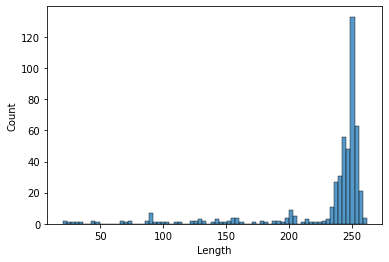

In [113]:
#print (kinases['Q9NYV4'].mechismo)
data = []
for acc in kinases:
    #print (kinases[acc].domains)
    for domainNum in kinases[acc].domains:
        #print (domainNum)
        data.append(len(kinases[acc].domains[domainNum]))

#print (data)
df = pd.DataFrame(data = data, columns=['Length'])
sns.histplot(data=df, x="Length")

In [134]:
def fetchPkinase(acc, domainNum):
    '''
    A function to take acc and alignment cutoff values to return
    the HMM bitscores
    '''
    row = []
    for hmmPosition in range(1,265):
        if hmmPosition in kinases[acc].domains[domainNum]:
            SeqPosition = kinases[acc].domains[domainNum][hmmPosition]
            aa = kinases[acc].fasta[SeqPosition-1]
            value = float(hmmPkinase[hmmPosition][aa])
        else:
            value = 3

        row.append(value)
    #print (len(row))
    kinases[acc].hmm[domainNum] = row
    return row

def fetchStrucFeat(acc, domainNum):
    data = []
    df = pd.DataFrame()
    for dic, name in zip([kinases[acc].dihedral, kinases[acc].sec, kinases[acc].burr, kinases[acc].access, kinases[acc].iupred, kinases[acc].mechismo],
                        ['dihedral', 'access', 'burr', 'sec', 'iupred', 'mechismo']):
        row = []
        for hmmPosition in range(1,265):
            if hmmPosition in kinases[acc].domains[domainNum]:
                SeqPosition = kinases[acc].domains[domainNum][hmmPosition]
                residue = kinases[acc].fasta[SeqPosition-1]
                #print (SeqPosition)
                try:
                    value = dic[SeqPosition][residue]
                except:
                    print (acc, SeqPosition, len(dic))
                    sys.exit()
            else:
                value = 3
            row.append(value)
        #f = pd.DataFrame(data, columns=AA)
        df[name] = row
    #print (df)
    return df
            
def oneHotEncoding(acc, domainNum):
    '''
    A function to take acc and alignment cutoff values to return
    the feature matrix (one hot encoded)
    '''
    AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    #print (len(AA))
    data = []
    numZeros = 0
    for i in range(1,265):
        if i in kinases[acc].domains[domainNum]:
            position = kinases[acc].domains[domainNum][i]
            residue = kinases[acc].fasta[position-1]
        else:
            residue = '-'

        row = []
        for aa in AA:
            if residue == aa:
                row.append(1)
            else:
                row.append(0)
        data.append(row)
        '''
        if acc == 'Q96NX5' and i == 173:
            print (residue)
            print (row)
        '''
    data = np.array(data)
    kinases[acc].oneHotEncoding[domainNum] = data
    '''
    if data.shape == (264,len(AA)):
        #print (data.shape)
        trainData.append(data)
    '''
            
    #trainData = np.array(trainData)
    #print (np.stack(trainData, axis=0).shape)
    return (data, AA)

df = pd.DataFrame()
trainData = []
alignmentCutoff = 200
for acc in kinases:
    for domainNum in kinases[acc].domains:
        if len(kinases[acc].domains[domainNum]) >= alignmentCutoff:
            
            data, AA = oneHotEncoding(acc, domainNum)
            df = pd.DataFrame(data, columns=AA)
            df['HMM'] = fetchPkinase(acc, domainNum)
            df = pd.concat([df, fetchStrucFeat(acc, domainNum)], axis=1)
            #print (acc, kinases[acc].hmm)
            trainData.append(df.to_numpy())
        #break

trainData = np.array(trainData)
np.stack(trainData, axis=0)
print (trainData.shape)
np.save('trainData.npy', trainData)
numSamples, numRows, numCols = trainData.shape

#for data in trainData:
#    print (data.shape)

(420, 264, 28)


In [136]:
trainData = np.load('trainData.npy')
print (trainData.shape)

(420, 264, 28)


In [132]:
## Create Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Built encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(numRows, numCols, 1))
x = layers.Conv2D(20, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(50, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


## Built decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(66 * 7 * 50, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Reshape((66, 7, 50))(x)
x = layers.Conv2DTranspose(50, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(20, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
#decoder_outputs = layers.Cropping2D(cropping=((0, 0), (0, 0)))(x)
#decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder_outputs)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 264, 28, 1)] 0                                            
______________________________________________________________________________________

In [133]:
## Define VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            '''
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            '''
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(
                        tf.subtract(data, reconstruction)
                    )
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print (trainData.shape)
trainData = trainData.reshape(numSamples, numRows, numCols, 1)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(trainData, epochs=50, batch_size=10)

(420, 264, 28, 1)
Epoch 1/50
42/42 [==============================] - 20s 438ms/step - loss: 29110.5973 - reconstruction_loss: 23320.9590 - kl_loss: 727.0120
Epoch 2/50
42/42 [==============================] - 18s 440ms/step - loss: 16955.5536 - reconstruction_loss: 16577.1094 - kl_loss: 126.6032
Epoch 3/50
42/42 [==============================] - 19s 449ms/step - loss: 16245.0421 - reconstruction_loss: 16080.4580 - kl_loss: 64.8831
Epoch 4/50
42/42 [==============================] - 19s 458ms/step - loss: 16252.9916 - reconstruction_loss: 15932.6396 - kl_loss: 47.9422
Epoch 5/50
42/42 [==============================] - 19s 449ms/step - loss: 15910.1348 - reconstruction_loss: 15803.4463 - kl_loss: 37.4679
Epoch 6/50
42/42 [==============================] - 18s 440ms/step - loss: 15843.1061 - reconstruction_loss: 15606.2139 - kl_loss: 31.6131
Epoch 7/50
33/42 [======================>.......] - ETA: 4s - loss: 15115.2375 - reconstruction_loss: 15420.7344 - kl_loss: 28.5391

KeyboardInterrupt: 

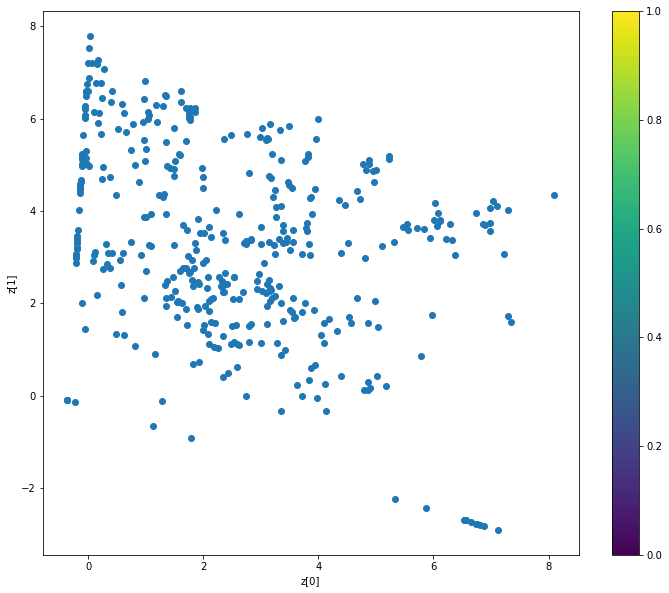

In [130]:
def plot_label_clusters(vae, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, trainData)
